In [5]:
import os
import subprocess
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import functions as F
from pyspark.sql.types import *

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [1]:
spark.conf.set("spark.sql.repl.eagerEval.enabled",True)

In [6]:
gcs_folder = 'gs://msca-bdp-data-open/final_project_git'

In [2]:
df_commits = spark.read.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/commits_sample.parquet")

#### Identify the most prolific / influential Committers

In [3]:
df_commits.printSchema()

root
 |-- author_name: string (nullable = true)
 |-- author_email: string (nullable = true)
 |-- author_time_sec: long (nullable = true)
 |-- committer_name: string (nullable = true)
 |-- committer_email: string (nullable = true)
 |-- commit: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- message: string (nullable = true)
 |-- repo_name: string (nullable = true)



In [6]:
# Group by committer_name and count the occurrences of each committer
committer_counts = df_commits.groupBy("committer_name") \
    .agg(F.count("*").alias("commit_count"))

# Sort by commit_count in descending order and get the top 10
top_10_committers = committer_counts.orderBy(F.col("commit_count").desc()).limit(10)

# Show the top 10 committers
top_10_committers.show()

+--------------------+------------+
|      committer_name|commit_count|
+--------------------+------------+
|      Linus Torvalds|    14478806|
|     David S. Miller|     9856617|
|  Greg Kroah-Hartman|     8515523|
|Mauro Carvalho Ch...|     4476031|
|    John W. Linville|     4224156|
|         Ingo Molnar|     4112400|
|              GitHub|     3399475|
|         Jeff Garzik|     2265168|
|     James Bottomley|     2112540|
|        Russell King|     2023108|
+--------------------+------------+



<Figure size 1000x600 with 0 Axes>

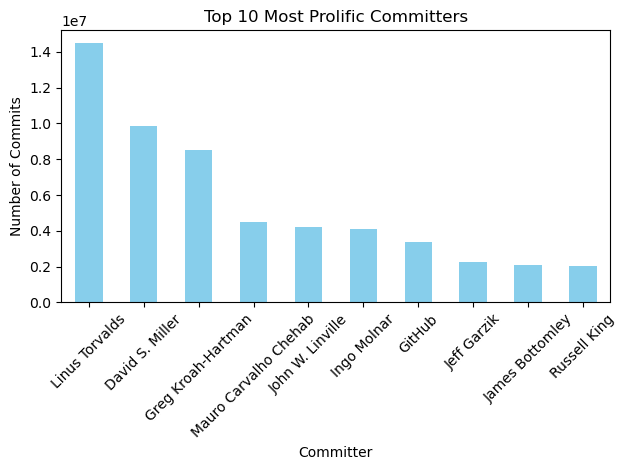

In [8]:
top_10_committers_pd = top_10_committers.toPandas()  # Convert to Pandas DataFrame

# Plotting using Pandas DataFrame
plt.figure(figsize=(10, 6))
top_10_committers_pd.plot(kind='bar', x='committer_name', y='commit_count', color='skyblue', legend=False)
plt.title('Top 10 Most Prolific Committers')
plt.xlabel('Committer')
plt.ylabel('Number of Commits')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

commits_sampled = df_commits.withColumn("commit_date", F.from_unixtime(F.col("author_time_sec")).cast("date"))
filtered_commits = commits_sampled.filter((F.col("commit_date") >= "2000-01-01") & (F.col("commit_date") <= "2025-02-28"))

commit_trends = (
    filtered_commits
    .withColumn("year", F.year("commit_date"))
    .groupBy("year", "committer_name")
    .count()
    .orderBy("year", "count", ascending=[True, False])
)

top_committers = commit_trends.groupBy("committer_name").sum("count").orderBy(F.desc("sum(count)")).limit(10)
top_committers_list = [row["committer_name"] for row in top_committers.collect()]

top_commit_trends = commit_trends.filter(F.col("committer_name").isin(top_committers_list))
top_commit_trends_pd = top_commit_trends.toPandas()

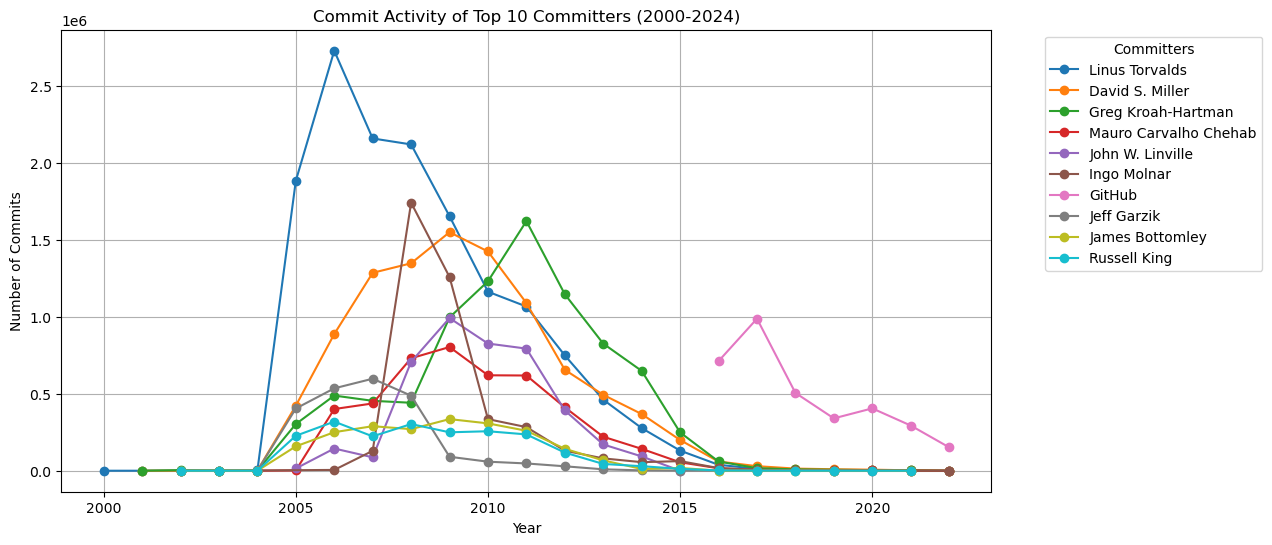

In [10]:
plt.figure(figsize=(12, 6))
for committer in top_committers_list:
    subset = top_commit_trends_pd[top_commit_trends_pd["committer_name"] == committer]
    plt.plot(subset["year"], subset["count"], marker="o", label=committer)

plt.xlabel("Year")
plt.ylabel("Number of Commits")
plt.title("Commit Activity of Top 10 Committers (2000-2024)")
plt.legend(title="Committers", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.show()

#### How unique are the “subject” and “message” values?

##### Are they mostly unique? Or are people usually just copy-pasting the same text?
##### You can use LSH to measure uniqueness / similarity
##### Visualize “subject” and “message” duplication across all programming languages
##### Visualize “subject” and “message” duplication for each of the top 5 programming languages
##### Please note: this is not a topic modeling (LDA / LSA) – but text similarity analysis

In [11]:
from pyspark.sql.functions import col, lower, regexp_replace, concat_ws, size
from pyspark.ml.feature import Tokenizer

df_cleaned = df_commits.select(
    lower(regexp_replace(col("subject"), r"[^a-zA-Z0-9\s]", "")).alias("subject_clean"),
    lower(regexp_replace(col("message"), r"[^a-zA-Z0-9\s]", "")).alias("message_clean")
).na.drop(subset=["subject_clean","message_clean"])

df_text = df_cleaned.withColumn("text", concat_ws(" ", col("subject_clean"), col("message_clean")))

tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
df_tokens = tokenizer.transform(df_text).filter(size(col("tokens")) > 0)

In [12]:
from pyspark.ml.feature import HashingTF, IDF
df_tokens = df_tokens.sample(fraction=0.001, seed=42)

# HashingTF
hashingTF = HashingTF(inputCol="tokens", outputCol="raw_features", numFeatures=128)
df_tf = hashingTF.transform(df_tokens)

# IDF for weighting
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(df_tf)
df_tfidf = idf_model.transform(df_tf)

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH

brp = BucketedRandomProjectionLSH(
    inputCol="features", 
    outputCol="hashes",
    bucketLength=1.0,   
    numHashTables=1     
)

brp_model = brp.fit(df_tfidf)
df_lsh = brp_model.transform(df_tfidf).cache()
df_lsh.count()

188504

In [15]:
threshold = 0.1
similar_pairs = brp_model.approxSimilarityJoin(
    df_lsh, df_lsh, threshold, distCol="euclid_dist"
).select("datasetA.text", "datasetB.text", "euclid_dist").filter("datasetA.text != datasetB.text")

dup_count = similar_pairs.count() 

In [16]:
duplicate_count = dup_count

#total_count = df_lsh.count()
total_count = 188504
unique_count = total_count - duplicate_count

print(f"Total lines: {total_count}")
print(f"Duplicate lines: {duplicate_count}")
print(f"Unique lines: {unique_count}")

Total lines: 188504
Duplicate lines: 16694
Unique lines: 171810


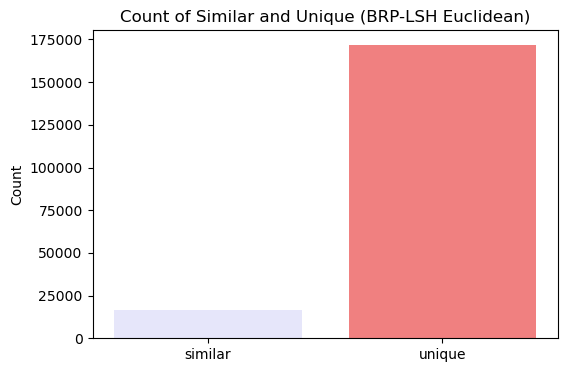

In [18]:
import matplotlib.pyplot as plt

labels = ["similar", "unique"]
values = [duplicate_count, unique_count]

plt.figure(figsize=(6,4))
plt.bar(labels, values, color=["lavender","lightcoral"])
plt.title("Count of Similar and Unique (BRP-LSH Euclidean)")
plt.ylabel("Count")
plt.show()

In [19]:
df_lang = spark.read.parquet("gs://msca-bdp-students-bucket/notebooks/aadyanair/Final Project/lang_sample.parquet")

In [20]:
df_lang.printSchema()

root
 |-- repo_name: string (nullable = true)
 |-- language_name: string (nullable = true)
 |-- language_bytes: long (nullable = true)



In [21]:
df_joined = df_commits.join(df_lang, on="repo_name", how="inner")
top_5_langs_df = (
    df_joined.groupBy("language_name")
    .count()
    .orderBy(F.desc("count"))
    .limit(5)
)

top_5_langs = [row["language_name"] for row in top_5_langs_df.collect()]

print("Top 5 languages by commit volume:")
print(top_5_langs)

Top 5 languages by commit volume:
['Shell', 'C++', 'Python', 'C', 'Perl']


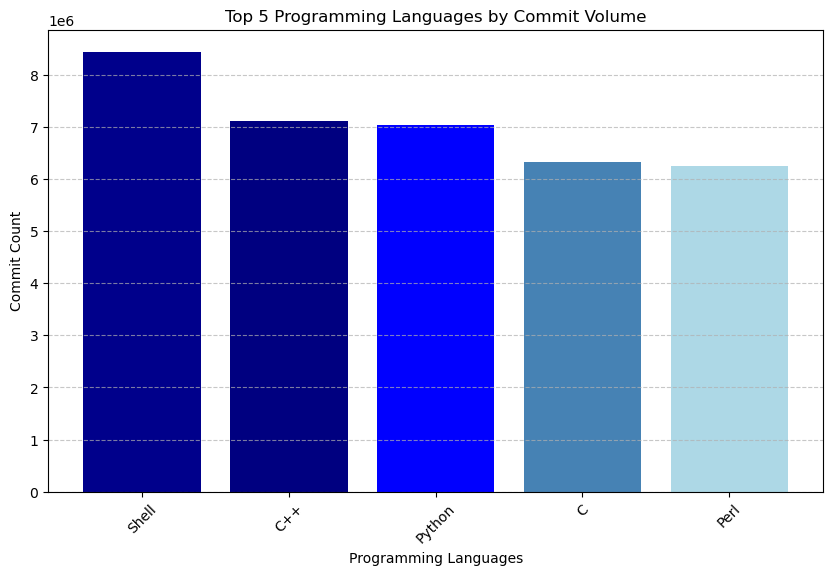

In [31]:
langs = [row["language_name"] for row in top_5_langs_df.collect()]
commit_counts = [row["count"] for row in top_5_langs_df.collect()]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(langs, commit_counts, color=["darkblue","navy" ,"blue", "steelblue",  "lightblue"])
plt.xlabel("Programming Languages")
plt.ylabel("Commit Count")
plt.title("Top 5 Programming Languages by Commit Volume")
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

In [22]:
def compute_duplication_for_language(df_lang, threshold=0.5, sample_fraction=0.001):
    
    df_cleaned = df_lang.select(
        lower(regexp_replace(col("subject"), r"[^a-zA-Z0-9\s]", "")).alias("subject_clean"),
        lower(regexp_replace(col("message"), r"[^a-zA-Z0-9\s]", "")).alias("message_clean")
    ).na.drop(subset=["subject_clean","message_clean"])
    
    df_text = df_cleaned.withColumn("text", concat_ws(" ", col("subject_clean"), col("message_clean")))
    
    tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
    df_tokens = tokenizer.transform(df_text).filter(size(col("tokens")) > 0)
    df_sampled = df_tokens.sample(fraction=sample_fraction, seed=42)
    
    hashingTF = HashingTF(inputCol="tokens", outputCol="raw_features", numFeatures=512)
    df_tf = hashingTF.transform(df_sampled)
    
    idf = IDF(inputCol="raw_features", outputCol="features")
    idf_model = idf.fit(df_tf)
    df_tfidf = idf_model.transform(df_tf)
    
    brp = BucketedRandomProjectionLSH(
        inputCol="features",
        outputCol="hashes",
        bucketLength=1.0,  # tune as needed
        numHashTables=1    # fewer tables => faster
    )
    brp_model = brp.fit(df_tfidf)
    df_lsh = brp_model.transform(df_tfidf)
    similar_pairs = brp_model.approxSimilarityJoin(
        df_lsh, df_lsh, threshold=threshold, distCol="euclid_dist"
    ).select(
        F.col("datasetA.text").alias("textA"),
        F.col("datasetB.text").alias("textB"),
        F.col("euclid_dist")
    ).filter("textA != textB")
    
    duplicate_count = similar_pairs.count()
    total_count = df_lsh.count()
    unique_count = total_count - duplicate_count
    
    return (duplicate_count, total_count, unique_count)

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.functions import col, lower, regexp_replace, concat_ws, size
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, BucketedRandomProjectionLSH
import matplotlib.pyplot as plt
import pandas as pd

results = []
for lang in top_5_langs:
    print(f"\n=== Processing language: {lang} ===")
    # Filter for this language
    df_lang = df_joined.filter(col("language_name") == lang)
    
    # Compute duplication stats
    dup_count, total_count, unique_count = compute_duplication_for_language(
        df_lang, threshold=0.5, sample_fraction=0.01
    )
    
    dup_ratio = dup_count / total_count if total_count > 0 else 0.0
    
    results.append((lang, dup_count, total_count, unique_count, dup_ratio))
    print(f"Total lines: {total_count}, Duplicates: {dup_count}, Unique: {unique_count}, Dup Ratio: {dup_ratio:.2%}")



=== Processing language: Shell ===


Total lines: 84771, Duplicates: 638, Unique: 84133, Dup Ratio: 0.75%

=== Processing language: C++ ===


Total lines: 71378, Duplicates: 226, Unique: 71152, Dup Ratio: 0.32%

=== Processing language: Python ===


Total lines: 70633, Duplicates: 314, Unique: 70319, Dup Ratio: 0.44%

=== Processing language: C ===


Total lines: 63484, Duplicates: 204, Unique: 63280, Dup Ratio: 0.32%

=== Processing language: Perl ===


Total lines: 62670, Duplicates: 140, Unique: 62530, Dup Ratio: 0.22%


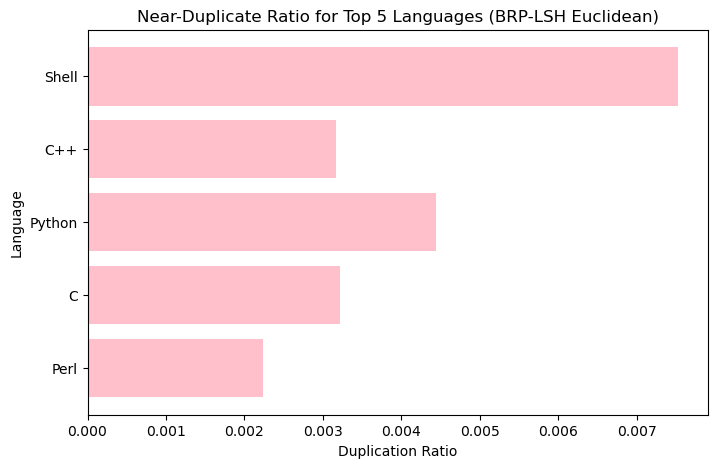


Final duplication stats per language:
  language  duplicate_count  total_count  unique_count  dup_ratio
0    Shell              638        84771         84133   0.007526
1      C++              226        71378         71152   0.003166
2   Python              314        70633         70319   0.004446
3        C              204        63484         63280   0.003213
4     Perl              140        62670         62530   0.002234


In [24]:
df_results = pd.DataFrame(results, columns=["language", "duplicate_count", "total_count", "unique_count", "dup_ratio"])

plt.figure(figsize=(8, 5))
plt.barh(df_results["language"], df_results["dup_ratio"], color="pink")
plt.xlabel("Duplication Ratio")
plt.ylabel("Language")
plt.title("Near-Duplicate Ratio for Top 5 Languages (BRP-LSH Euclidean)")
plt.gca().invert_yaxis()
plt.show()

print("\nFinal duplication stats per language:")
print(df_results)

In [33]:
styled_df = df_results.style.background_gradient(cmap="Blues") \
    .set_table_styles([{"selector": "th", "props": [("font-size", "14px"), ("background", "#1f77b4"), ("color", "white")]}]) \
    .set_properties(**{"text-align": "center", "font-size": "12px"}) \
    .format({"dup_ratio": "{:.2%}"})  # Formatting dup_ratio as a percentage

styled_df

,language,duplicate_count,total_count,unique_count,dup_ratio
0,Shell,638,84771,84133,0.75%
1,C++,226,71378,71152,0.32%
2,Python,314,70633,70319,0.44%
3,C,204,63484,63280,0.32%
4,Perl,140,62670,62530,0.22%
